## Navigation MDP [1]

In [1]:
import numpy as np
from simple_rl.tasks import NavigationMDP
from simple_rl.planning import ValueIteration
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Create navigation mdp, ~as specified in [1]
nvmdp = NavigationMDP(width=30, 
                        height=30, 
                        goal_locs=[(21,21)], 
                        init_loc=(1,1), 
                        rand_init=True,
                        cell_types=["empty", "yellow", "red", "green", "purple"],
                        cell_rewards=[0, 0, -10, -10, -10],
                        goal_reward=1.,
                        slip_prob=0.00,
                        step_cost=0.0,
                        gamma=.9999)
value_iter = ValueIteration(nvmdp, sample_rate=3)
_ = value_iter.run_vi()

In [3]:
# Sample expert trajectories
trajectories = []
for i in range(4):
    action_seq, state_seq = value_iter.plan(nvmdp.get_random_init_state())
    trajectories.append(state_seq)

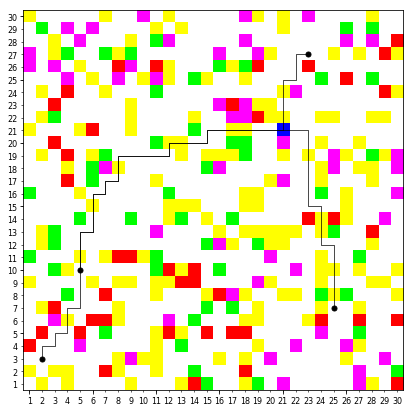

In [4]:
# Visualize navigation grid
nvmdp.visualize_grid(trajectories=trajectories)

## Reference

[1] MacGlashan, James, and Michael L. Littman. "Between Imitation and Intention Learning." IJCAI. 2015.